In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
import tqdm
import random
import glob

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

tf.random.set_seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

In [36]:
class GAN(keras.Model):
    def __init__(self, x_dim, z_dim): # dim: tuple
        super(GAN, self).__init__()
        self.x_dim  = x_dim
        self.z_dim = z_dim

        self.m = 1
        self.lambda_pt = 0.1
        
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
    def compile(self, g_optim, d_optim, loss_fn):
        super(GAN, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.loss_fn = loss_fn
        
    def build_generator(self): 
        activation = 'relu'
        inputs = Input(shape=(self.z_dim, ))
        h = Dense(256)(inputs)
        h = Activation(activation)(h)
        h = BatchNormalization(momentum=0.8)(h)
        
        h = Dense(512)(h)
        h = Activation(activation)(h)
        h = BatchNormalization(momentum=0.8)(h)
        
        h = Dense(1024)(h)
        h = Activation(activation)(h)
        
        outputs = Dense(self.x_dim[0], activation='tanh')(h)
        
        return Model(inputs, outputs, name='generator')

    def build_discriminator(self):
        activation = 'relu'
        inputs = Input(shape = self.x_dim)
        h = Dense(512)(inputs)
        h = Activation(activation)(h)
        h = Dense(256)(h)
        h = Activation(activation)(h)
        
        m = Dense(100)(h)
        
        h = Dense(256)(m)
        h = Activation(activation)(h)
        h = Dense(512)(h)
        h = Activation(activation)(h)
        
        outputs = Dense(self.x_dim[0])(h)

        return Model(inputs, [outputs, m], name='discriminator')
    
    def train_step(self, x):
        batch_size = tf.shape(x)[0]
        
#         fake_labels = tf.ones((batch_size, 1))
#         real_labels = tf.ones((batch_size, 1))*0
#         labels = tf.concat([real_labels, fake_labels], 0)
        
        noise = tf.random.normal((batch_size, self.z_dim))
        
        # discriminator
        with tf.GradientTape() as tape:
            d_real, _ = self.discriminator(x)
            real_loss = self.loss_fn(x, d_real)
            
            fake = self.generator(noise)
            d_fake, _ = self.discriminator(fake)
            fake_loss = self.loss_fn(fake, d_fake)
            
            d_loss = real_loss + tf.nn.relu(self.m-fake_loss)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # generator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            preds, emb = self.discriminator(fake)
            
            pt_loss = self.pullaway_loss(emb)
            recon_loss = self.loss_fn(fake, preds)
            g_loss = recon_loss + self.lambda_pt * pt_loss
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}
    
    def pullaway_loss(self, embeddings):
        norm = tf.sqrt(tf.reduce_sum(embeddings ** 2, -1, keepdims=True))
        normalized_emb = embeddings / norm
        similarity = tf.matmul(normalized_emb, tf.transpose(normalized_emb, (1, 0)))
        batch_size = tf.shape(embeddings)[0]
        batch_size = tf.cast(batch_size, 'float32')
        loss_pt = (tf.reduce_sum(similarity) - batch_size) / (batch_size * (batch_size - 1))
        return loss_pt

In [28]:
class PlotCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            r, c = 2, 5
            noise = np.random.normal(0, 1, (r*c, 100))
            imgs = self.model.generator.predict(noise)*0.5 +0.5
            imgs = imgs.reshape(r*c, 28, 28)
            fig, axs = plt.subplots(r, c)
            n = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(imgs[n], cmap='gray')
                    axs[i,j].axis('off')
                    n += 1
            plt.show()
            plt.close()

In [29]:
from tensorflow.keras.datasets import mnist
(train_X, train_y), (_, _) = mnist.load_data()
train_X = (train_X - 127.5)/127.5
train_X = train_X.reshape(-1, 28*28)

In [37]:
gan = GAN(train_X.shape[1:], 100)
gan.generator.summary()
print('#'*50)
gan.discriminator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               25856     
_________________________________________________________________
activation_14 (Activation)   (None, 256)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_21 (Dense)             (None, 512)               131584    
_________________________________________________________________
activation_15 (Activation)   (None, 512)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               20

Epoch 1/101
1870/1875 [============================>.] - ETA: 0s - d_loss: 0.5879 - g_loss: 1.9600

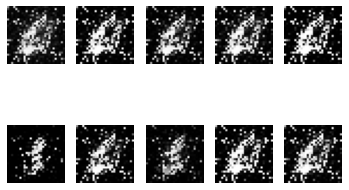

1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.5869 - g_loss: 1.9589
Epoch 2/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.2460 - g_loss: 2.9182
Epoch 3/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.2377 - g_loss: 2.7308
Epoch 4/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.1770 - g_loss: 2.2412
Epoch 5/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.1522 - g_loss: 2.1447
Epoch 6/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.0973 - g_loss: 3.4113
Epoch 7/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.0681 - g_loss: 3.8655
Epoch 8/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.0656 - g_loss: 1.6280
Epoch 9/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.0539 - g_loss: 1.6414
Epoch 10/101
1875/1875 [==============================] - 14s 7ms/step - d_l

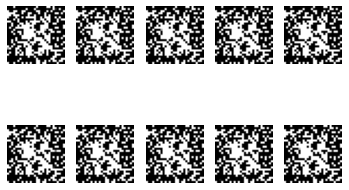

1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.0631 - g_loss: 2.1390
Epoch 12/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.0570 - g_loss: 2.1990
Epoch 13/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.0929 - g_loss: 2.2544
Epoch 14/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.1189 - g_loss: 2.5496
Epoch 15/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.1277 - g_loss: 2.1458
Epoch 16/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.1027 - g_loss: 1.6749
Epoch 17/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.1467 - g_loss: 2.2584
Epoch 18/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.1339 - g_loss: 2.1370
Epoch 19/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.1703 - g_loss: 1.7446
Epoch 20/101
1875/1875 [==============================] - 14s 7ms/st

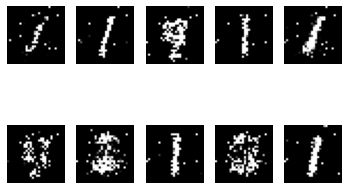

1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.1797 - g_loss: 1.4617
Epoch 22/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.2476 - g_loss: 1.7287
Epoch 23/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.2967 - g_loss: 1.5052
Epoch 24/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.3588 - g_loss: 1.4849
Epoch 25/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.3534 - g_loss: 1.5789
Epoch 26/101
1875/1875 [==============================] - 7s 4ms/step - d_loss: 0.3595 - g_loss: 1.6025
Epoch 27/101
1875/1875 [==============================] - 7s 4ms/step - d_loss: 0.3498 - g_loss: 1.5913
Epoch 28/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.3590 - g_loss: 1.5819
Epoch 29/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.3824 - g_loss: 1.5034
Epoch 30/101
1875/1875 [==============================] - 13s 7ms/step 

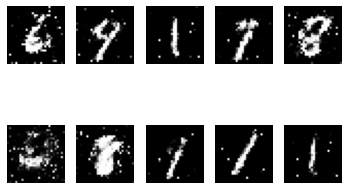

1875/1875 [==============================] - 14s 8ms/step - d_loss: 0.3996 - g_loss: 1.5358
Epoch 32/101
1875/1875 [==============================] - 14s 8ms/step - d_loss: 0.4010 - g_loss: 1.4843
Epoch 33/101
1875/1875 [==============================] - 15s 8ms/step - d_loss: 0.3917 - g_loss: 1.5753
Epoch 34/101
1875/1875 [==============================] - 14s 8ms/step - d_loss: 0.3968 - g_loss: 1.5716
Epoch 35/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.3887 - g_loss: 1.5736
Epoch 36/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4057 - g_loss: 1.5363
Epoch 37/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4281 - g_loss: 1.5564
Epoch 38/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4166 - g_loss: 1.5031
Epoch 39/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4109 - g_loss: 1.5518
Epoch 40/101
1875/1875 [==============================] - 13s 7ms/st

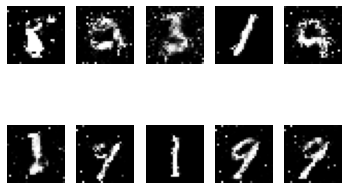

1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.3928 - g_loss: 1.5859
Epoch 42/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.4360 - g_loss: 1.5171
Epoch 43/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.4450 - g_loss: 1.5382
Epoch 44/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4151 - g_loss: 1.4792
Epoch 45/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.4113 - g_loss: 1.5443
Epoch 46/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4243 - g_loss: 1.4956
Epoch 47/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.4025 - g_loss: 1.5110
Epoch 48/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.3951 - g_loss: 1.5108
Epoch 49/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4208 - g_loss: 1.4746
Epoch 50/101
1875/1875 [==============================] - 14s 7ms/st

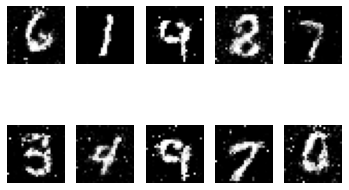

1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.4297 - g_loss: 1.5196
Epoch 52/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4277 - g_loss: 1.5497
Epoch 53/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4589 - g_loss: 1.4887
Epoch 54/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.4221 - g_loss: 1.5311
Epoch 55/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4101 - g_loss: 1.4787
Epoch 56/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4169 - g_loss: 1.5154
Epoch 57/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4143 - g_loss: 1.5631
Epoch 58/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4143 - g_loss: 1.5553
Epoch 59/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4081 - g_loss: 1.5296
Epoch 60/101
1875/1875 [==============================] - 13s 7ms/st

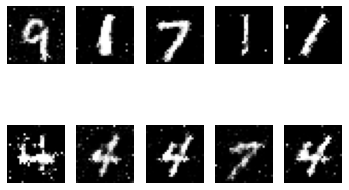

1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.4013 - g_loss: 1.5142
Epoch 62/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.3998 - g_loss: 1.5787
Epoch 63/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.4190 - g_loss: 1.5504
Epoch 64/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.3960 - g_loss: 1.4998 0s - d_loss: 0.3962 - g_loss
Epoch 65/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.4063 - g_loss: 1.4861
Epoch 66/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.4312 - g_loss: 1.5135
Epoch 67/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4376 - g_loss: 1.4999
Epoch 68/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4251 - g_loss: 1.5322
Epoch 69/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4212 - g_loss: 1.5005
Epoch 70/101
1875/1875 [===============

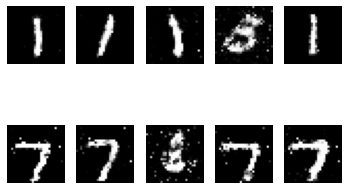

1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4051 - g_loss: 1.6252
Epoch 72/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.4187 - g_loss: 1.5789
Epoch 73/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4167 - g_loss: 1.5131
Epoch 74/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4034 - g_loss: 1.4923
Epoch 75/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4043 - g_loss: 1.4466
Epoch 76/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4258 - g_loss: 1.4420
Epoch 77/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.3908 - g_loss: 1.6002
Epoch 78/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.3972 - g_loss: 1.4927
Epoch 79/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.3960 - g_loss: 1.5000
Epoch 80/101
1875/1875 [==============================] - 13s 7ms/st

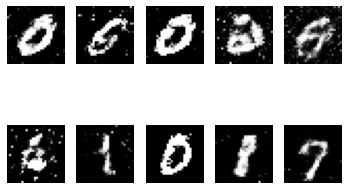

1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4320 - g_loss: 1.5335
Epoch 82/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.3988 - g_loss: 1.4990
Epoch 83/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.3866 - g_loss: 1.6916
Epoch 84/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.3687 - g_loss: 1.5739
Epoch 85/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.3913 - g_loss: 1.5808
Epoch 86/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.3899 - g_loss: 1.5619
Epoch 87/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.3888 - g_loss: 1.6228
Epoch 88/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.3913 - g_loss: 1.5081
Epoch 89/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.3755 - g_loss: 1.4902
Epoch 90/101
1875/1875 [==============================] - 13s 7ms/st

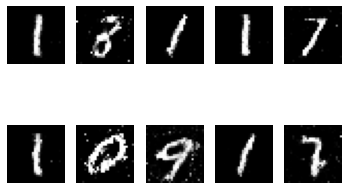

1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.3928 - g_loss: 1.4678
Epoch 92/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.4020 - g_loss: 1.4992
Epoch 93/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4018 - g_loss: 1.4316
Epoch 94/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4124 - g_loss: 1.5985
Epoch 95/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.3752 - g_loss: 1.6701
Epoch 96/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4146 - g_loss: 1.4764
Epoch 97/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4328 - g_loss: 1.5014
Epoch 98/101
1875/1875 [==============================] - 13s 7ms/step - d_loss: 0.4096 - g_loss: 1.5874
Epoch 99/101
1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.3881 - g_loss: 1.6607
Epoch 100/101
1875/1875 [==============================] - 14s 7ms/s

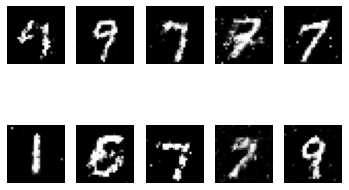

1875/1875 [==============================] - 14s 7ms/step - d_loss: 0.3859 - g_loss: 1.5554


In [38]:
gan.compile(
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    losses.MeanSquaredError(), 
         )

gan.fit(train_X,
       epochs=101,
       shuffle=True,
       batch_size=32,
       callbacks=[PlotCallback()])